In [1]:
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import qacits.qacits_vlt_package_v4 as qacits
from photutils import CircularAperture, aperture_photometry
from configobj import ConfigObj
import os
from scipy.stats import linregress
import astropy.units as u
import os.path

# Input parameters

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/CODE/Python/qacits')))
case = 'test'
suffix = '_lyotstop'
band = 'L'
mode = 'CVC'
dir_data = 'data/%s_band'%band
f_ref = 'offaxis_PSF_%s_%s.fits'%(band, mode)
f_sci_cube = 'calib.fits'
f_offsets = 'calib_tt.fits'
# The binning factor will depend on the number of frames needed to build up
# a sufficient SNR (needs to be studied)
n_bin           = 0 # if 0: no averaging, every estimates are returned in a 2D array
                    # if 1: average all frames before computing the estimate
                    # if n_bin=integer < n_img: will return as many estimates (frames are 
                    # averaged by bins of n_img/n_bin before computing the estimates).
# display options
disp_plots      = True
colors = {'inner':[0.,0.3,.7],'outer':[.7,0.,0.3],'full':[0.,.7,0.5]}
crop = 150
# file with QACITS model parameters
inst = 'no-model' #'old-model' 'new-model' 'model_v201907'
if 'old-model' in inst:
    param_file = 'qacits_model_params_near002.ini'
elif 'new-model' in inst:
    param_file = 'qacits_model_params_near002_new.ini'
elif 'no-model' in inst:
    param_file = 'qacits_model_params_noinstr.ini'
elif 'model_v201907' in inst:
    param_file = 'qacits_model_params_near002_v201907.ini'
# output directory
dir_out = os.path.join(dir_data, case, inst)
os.makedirs(dir_out, exist_ok=True)
# Image sampling given in pixels per lambda/D
conf = update_config(**dict(read_config(), band=band, mode=mode))
sampling = conf['lam']/conf['diam_ext']/(conf['pscale']*u.mas.to('rad'))
print('sampling = %s pix per lam/D'%np.round(sampling, 2))
# FWHM including Lyot-stop
FWHM = sampling/(1 - conf['ls_dRext'])
print('FWHM = %s pix'%np.round(FWHM, 2))

sampling = 3.89 pix per lam/D
FWHM = 4.01 pix


# Reference off-axis PSF

n_ref=403, min=0.0, max=0.03
Iref_qacits=[0.23462]
Iref_enc=0.22572, Iref_tot=0.7289


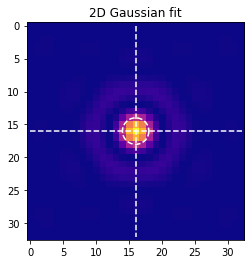

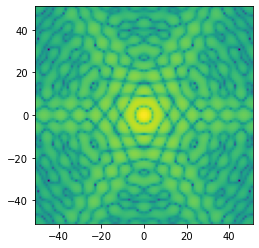

In [3]:
ref_frame = fits.getdata(os.path.join(dir_data, f_ref))
assert ref_frame.ndim == 2, 'off-asis PSF must be one frame'
n_ref = ref_frame.shape[-1]
c_ref = n_ref // 2
print('n_ref=%s, min=%s, max=%s'%(n_ref, np.round(np.min(ref_frame),2), np.round(np.max(ref_frame),2)))
# QACITS flux estimate
Iref_qacits = qacits.get_psf_flux_v7(ref_frame, 0.5, FWHM, cyx_guess=(c_ref, c_ref), 
                                    display=disp_plots, do_norm=False)
print('Iref_qacits=%s'%np.round(Iref_qacits,5))
# photutils aperture photometry
ref_aper = CircularAperture((c_ref, c_ref), r=FWHM/2)
Iref_enc = aperture_photometry(ref_frame, ref_aper)['aperture_sum'].data[0]
Iref_tot = np.sum(ref_frame)
print('Iref_enc=%s, Iref_tot=%s'%(np.round(Iref_enc,5), np.round(Iref_tot,5)))
plt.figure()
xymin, xymax = crop - c_ref, c_ref - crop
plt.imshow(np.log10(ref_frame[crop:-crop,crop:-crop]), extent=[xymin, xymax, xymin, xymax], origin='lower');

# Science cube: on-axis PSFs with tip-tilt

n_cube = 220, n_sci = 403
frame #90, tt=[0.09 0.  ]
Isci_enc=0.00049, Isci_tot=0.02507
frame #200, tt=[0.   0.09]
Isci_enc=0.00049, Isci_tot=0.02507


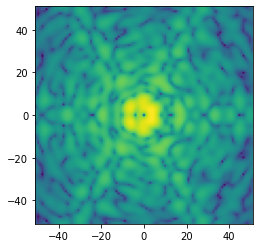

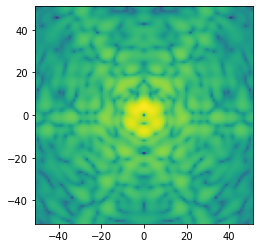

In [4]:
sci_cube = fits.getdata(os.path.join(dir_data, f_sci_cube))
sci_cube = qacits.bin_images(sci_cube, n_bin)
n_cube = sci_cube.shape[0]
n_sci = sci_cube.shape[-1]
c_sci = n_sci // 2
print('n_cube = %s, n_sci = %s'%(n_cube, n_sci))
offsets = fits.getdata(os.path.join(dir_data, f_offsets)).T
offsets_m = np.sqrt(offsets[:,0]**2 + offsets[:,1]**2)
# photutils aperture photometry
Isci_enc = []
Isci_tot = []
sci_aper = CircularAperture((c_sci, c_sci), r=FWHM/2)
for sci_frame in sci_cube:
    Isci_enc.append(aperture_photometry(sci_frame, sci_aper)['aperture_sum'].data[0])
    Isci_tot.append(np.sum(sci_frame))
xymin, xymax = crop - c_sci, c_sci - crop
iframe=90
print('frame #%s, tt=%s'%(iframe,offsets[iframe]))
print('Isci_enc=%s, Isci_tot=%s'%(np.round(Isci_enc[iframe],5), np.round(Isci_tot[iframe],5)))
plt.imshow(np.log10(sci_cube[iframe,crop:-crop,crop:-crop]), extent=[xymin, xymax, xymin, xymax], origin='lower');
iframe=200
print('frame #%s, tt=%s'%(iframe,offsets[iframe]))
print('Isci_enc=%s, Isci_tot=%s'%(np.round(Isci_enc[iframe],5), np.round(Isci_tot[iframe],5)))
plt.figure()
plt.imshow(np.log10(sci_cube[iframe,crop:-crop,crop:-crop]), extent=[xymin, xymax, xymin, xymax], origin='lower');

# Transmission

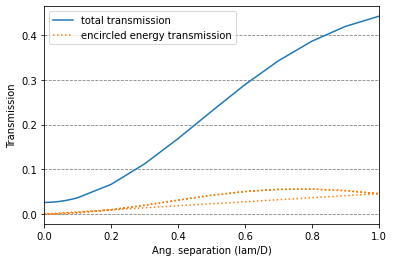

In [5]:
T_enc = np.array(Isci_enc)/Iref_enc
T_tot = Isci_tot/Iref_tot
plt.figure(num=31)
plt.plot(offsets_m[-110:], T_tot[-110:], label='total transmission')
plt.plot(offsets_m, T_enc, ':', label='encircled energy transmission')
plt.xlim(0, max(offsets_m))
plt.xlabel('Ang. separation (lam/D)')
plt.ylabel('Transmission')
plt.grid(axis='y', color='.5', linestyle='--')
plt.legend(frameon=True);

# Tip-tilt estimate

qacits_params {'radii': {'inner': (0.0, 1.7), 'outer': (1.7, 2.3), 'full': (0.0, 1.7)}, 'inner_slope': 1.0, 'outer_slope': 1.0, 'full_coeff': 1.0, 'ratio': 0.0, 'phase_tolerance': 60.0, 'modul_tolerance': 0.33, 'small_tt_regime': 0.3, 'large_tt_regime': 0.2}
slopes  {'inner': 0.23443478833796988, 'outer': 0.10079109417240986, 'full': -0.3189220947160477}


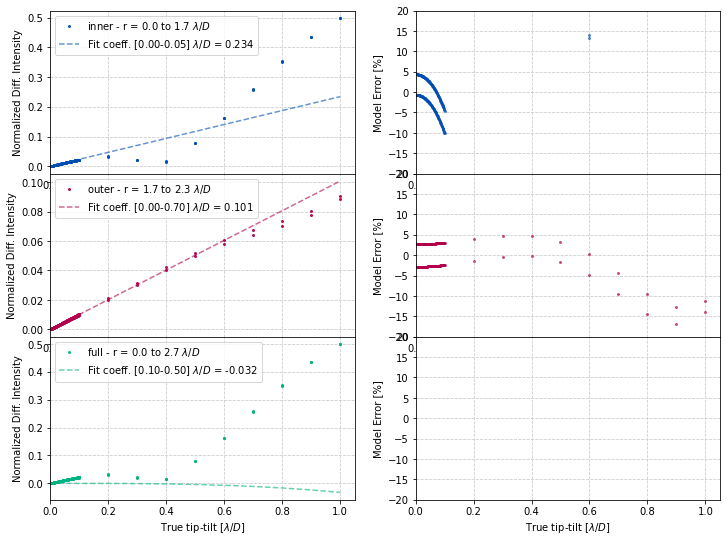

In [6]:
qacits_params = ConfigObj(param_file, unrepr=True)
print('qacits_params', qacits_params)
tiptilt_estimate_full = qacits.quadrant_tiptilt_v7b(qacits_params, sci_cube, (c_sci, c_sci), 
                        Iref_qacits[0], sampling, verbose=False, exact=True, force = None)
#--- Final estimator
tiptilt_estimate = tiptilt_estimate_full[:,0:2]
#--- Other estimators (r, theta) -> (x,y)
inner_rt = tiptilt_estimate_full[:,2:4] 
inner_xy = np.vstack((inner_rt[:,0] * np.cos(inner_rt[:,1]), 
                      inner_rt[:,0] * np.sin(inner_rt[:,1]))).T
outer_rt = tiptilt_estimate_full[:,4:6] 
outer_xy = np.vstack((outer_rt[:,0] * np.cos(outer_rt[:,1]), 
                      outer_rt[:,0] * np.sin(outer_rt[:,1]))).T
full_rt = tiptilt_estimate_full[:,6:8] 
full_xy = np.vstack((full_rt[:,0] * np.cos(full_rt[:,1]), 
                     full_rt[:,0] * np.sin(full_rt[:,1]))).T
# TT SCAN DATA: inst CALIBRATION
colors = {'inner':[0.,0.3,.7],'outer':[.7,0.,0.3],'full':[0.,.7,0.5]}
slopes = {}
model_order = {'inner':1,'outer':1,'full':3}
plt.figure(num=17, figsize=(12,9))
fig, ax = plt.subplots(nrows=3,ncols=2,num=17)
fig.subplots_adjust(hspace=0)
tt_fit_lim  = {'inner': (0., 0.05),
               'outer': (0., 0.7),
               'full':  (0.1, 0.5)}
ind_sort = np.argsort(offsets_m)
calib_tt = offsets_m[ind_sort]
radii = {'inner': (0.0, 1.7), 'outer': (1.7, 2.3), 'full':  (0., 2.7)}
for i, region in enumerate(tt_fit_lim):
    ind_x = np.where((calib_tt>tt_fit_lim[region][0]) & 
                     (calib_tt<tt_fit_lim[region][1]))[0]
    x = calib_tt[ind_x]
    if   region == 'inner':
        yy  = inner_rt[ind_sort,0]
    elif region == 'outer':
        yy  = outer_rt[ind_sort,0]
    elif region == 'full':
        yy  = full_rt[ind_sort,0]
    y = yy[ind_x]
    lin_params = linregress(x,y)
    slopes[region] = lin_params.slope
#            ax[i].set_title(region)
    ax[i,0].set_xlabel(r'True tip-tilt [$\lambda/D$]')
    ax[i,0].set_ylabel('Normalized Diff. Intensity')
    ax[i,0].plot(calib_tt, yy**model_order[region], 'o', 
               color=colors[region], alpha=.9, markersize=2,
               label=region+r' - r = {0:.1f} to {1:.1f} $\lambda/D$'
               .format(radii[region][0], radii[region][1]))
    ax[i,0].plot(calib_tt, calib_tt**model_order[region]*slopes[region]**model_order[region], 
               color=colors[region], alpha=.6, linestyle='--', 
               label=r'Fit coeff. [{0:.2f}-{1:.2f}] $\lambda/D$ = {2:.3f}'
               .format(tt_fit_lim[region][0],tt_fit_lim[region][1],slopes[region]**model_order[region]))
    ax[i,0].grid(color='.8',linestyle='--')
    ax[i,0].set_xlim(0.,)
#            ax[i,0].set_ylim(0.,.0s07)
    ax[i,0].legend()
    
    error = ((yy**model_order[region] - 
              calib_tt**model_order[region]*slopes[region]**model_order[region]) /
              yy**model_order[region]) * 100.
    ax[i,1].set_xlabel(r'True tip-tilt [$\lambda/D$]')
    ax[i,1].set_ylabel('Model Error [%]')
    ax[i,1].plot(calib_tt, error, 
               'o', markersize=2, color=colors[region], alpha=.6)
    ax[i,1].set_ylim(-20., 20.)
    ax[i,1].set_xlim(0.,)
    ax[i,1].grid(color='.8',linestyle='--')

print('slopes ', slopes)

In [7]:
# normalize sci cube
sci_cube /= Iref_qacits

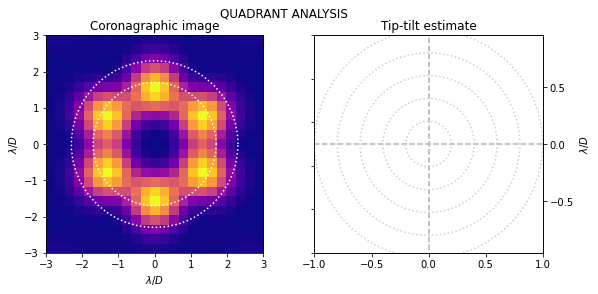

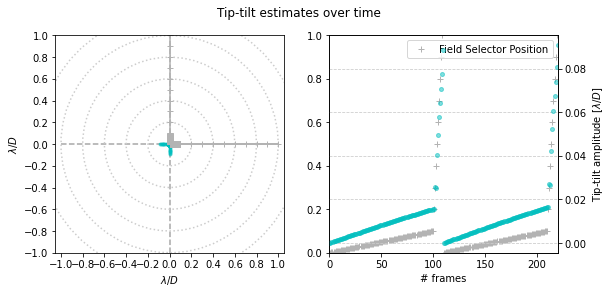

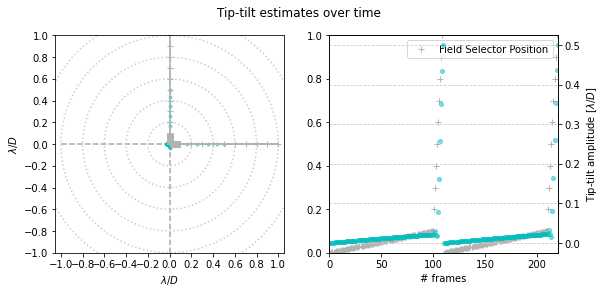

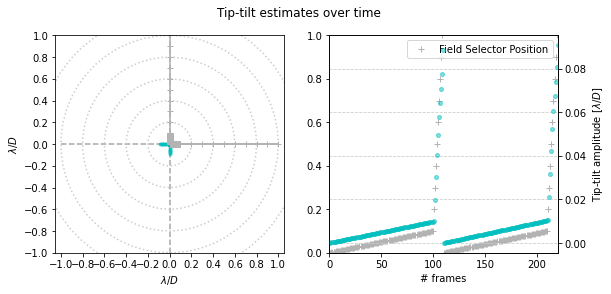

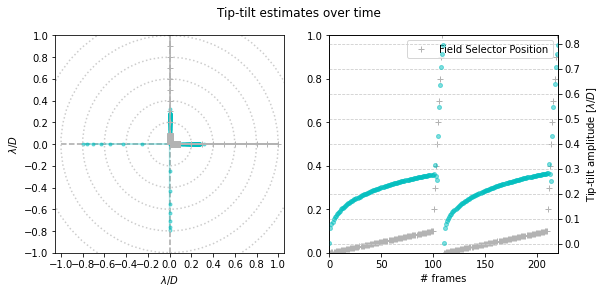

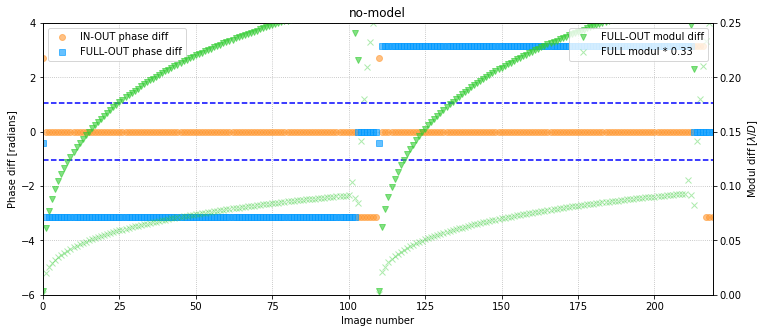

In [8]:
## DISPLAY ###################################################################
if disp_plots is True:    
    #-- Conversion in polar coordinates
    tt_rt = np.zeros_like(tiptilt_estimate)
    tt_rt[:,0] = np.sqrt(tiptilt_estimate[:,0]**2+tiptilt_estimate[:,1]**2)
    tt_rt[:,1] = np.arctan2(tiptilt_estimate[:,1],tiptilt_estimate[:,0]) * 180./np.pi
    #-- some parameters for display
    subim_width_lbdd = 3.
    inner_rad_lbdd  = 1.7
    outer_rad_lbdd  = 2.3
    #-- Quadrant analysis results for the last image
    img_i = 0 #20
    delta_t = None #0.016666666 #0.2166
    n_tt = len(tiptilt_estimate[:,0])
    fig1, ax1 = qacits.display_tiptilt_target(sci_cube[img_i], sampling, (n_sci//2, n_sci//2),
                                       tiptilt_estimate[img_i], subim_width_lbdd=subim_width_lbdd, 
                                       fig_num=41, tt_lim=1., plot_title='QUADRANT ANALYSIS',
                                       img_circ_rad=(inner_rad_lbdd, outer_rad_lbdd), 
                                       tt_circ_rad=(.2,.4,.6,.8,1.))
    #-- plot all estimates
    tt = (0,n_tt)
    tt_circ_rad = (.2,.4,.6,.8,1., 1.2)
    #There seems to be rescaling of the field selector amplitudes in the right plots
    #depending on the selected estimator?!
    #-- Add the FS position to the plots
    def add_FS(ax, fs_color='.7', fs_symbol='+'):
        ax[0].plot(offsets[:,0], offsets[:,1], marker=fs_symbol, color=fs_color)
        ax[1].plot(offsets_m, fs_symbol, color=fs_color, label='Field Selector Position')
        ax[1].set_ylim(0, np.max(offsets_m)) #np.max(tt_circ_rad))
        ax[1].set_xlim(0, n_cube)
        ax[1].legend()
    
    fig, ax = qacits.display_tiptilt_sequence(tiptilt_estimate[tt[0]:tt[1]], delta_t=delta_t, tt_circ_rad=tt_circ_rad, fignum=42)
    add_FS(ax)
    plt.savefig(os.path.join(dir_out, '%s_%s_tiptilt_estimator%s.png'%(f_sci_cube[:-5], inst, suffix)), dpi=150, bbox_inches='tight')
    fig, ax = qacits.display_tiptilt_sequence(inner_xy[tt[0]:tt[1]], delta_t=delta_t, tt_circ_rad=tt_circ_rad, fignum=50)
    add_FS(ax)
    plt.savefig(os.path.join(dir_out, '%s_%s_tiptilt_inner_estimator%s.png'%(f_sci_cube[:-5], inst, suffix)), dpi=150, bbox_inches='tight')
    fig, ax = qacits.display_tiptilt_sequence(outer_xy[tt[0]:tt[1]], delta_t=delta_t, tt_circ_rad=tt_circ_rad, fignum=51)
    add_FS(ax)
    plt.savefig(os.path.join(dir_out, '%s_%s_tiptilt_outer_estimator%s.png'%(f_sci_cube[:-5], inst, suffix)), dpi=150, bbox_inches='tight')
    fig, ax = qacits.display_tiptilt_sequence(full_xy[tt[0]:tt[1]], delta_t=delta_t, tt_circ_rad=tt_circ_rad, fignum=52)
    add_FS(ax)
    plt.savefig(os.path.join(dir_out, '%s_%s_tiptilt_full_estimator%s.png'%(f_sci_cube[:-5], inst, suffix)), dpi=150, bbox_inches='tight')

    inout_phase_diff = tiptilt_estimate_full[:,8:11][:,0]
    fullout_phase_diff = tiptilt_estimate_full[:,8:11][:,1]
    fullout_modul_diff = tiptilt_estimate_full[:,8:11][:,2]
    plt.figure(num=0, figsize=(12,5))
    figg, axx = plt.subplots(num=0)
    axx.plot(inout_phase_diff, 'o', label='IN-OUT phase diff', alpha=.6, color=(1,.6,.2))
    axx.plot(fullout_phase_diff, 's', label='FULL-OUT phase diff', alpha=.6, color=(0,.6,1))
    axx.hlines((60.*np.pi/180.,-60.*np.pi/180.), 0, n_tt, color='b', linestyle='--')
    axx.grid(color='.7', linestyle=':')
    axx.set_ylim(-6., 4)
    axx.set_ylabel('Phase diff [radians]')
    axx.set_xlabel('Image number')
    axx.legend(loc=2)
    axx.set_title(inst)
    axx2 = axx.twinx()
    axx2.plot(fullout_modul_diff, 'v', label='FULL-OUT modul diff', alpha=.6, color=(.2,.8,.2))
    axx2.plot(full_rt[:,0]*.33, 'x', label='FULL modul * 0.33', alpha=.4, color=(.2,.8,.2))
    #axx2.grid(color='.8', linestyle='--')
    axx2.set_ylim(0,.25)
    axx2.set_ylabel(r'Modul diff [$\lambda/D$]')
    axx2.legend(loc=1)
    axx2.set_xlim(0,n_tt-1)
    plt.savefig(os.path.join(dir_out, '%s_%s_estimator_agreement_checks%s.png'%(f_sci_cube[:-5], inst, suffix)), dpi=150, bbox_inches='tight');